In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import traces

In [2]:
#import sys
#import subprocess
#subprocess.check_call([sys.executable,"-m","pip","install","pyxdf"])

In [3]:
electrodes =['F7','F3','Fz','F4','F8','T7','C3','C4','T8','P7','P3','Pz','P4','P8','O1','O2']
electrode_map = { el : ii for ii,el in enumerate(electrodes) }

In [4]:
ss='001'

In [5]:
filename ='../eeg/sub-P'+ss+'_ses-S001_task-T1_run-001_eeg.xdf'
data, header = pyxdf.load_xdf(filename,synchronize_clocks=True)

In [6]:
myStreams = []

In [7]:
# Standarize streams
for stream in data:
    if stream['info']['name'][0] == 'visual_oddball_Mrkrs':
        myStreams.insert(0,stream)
    if stream['info']['name'][0] == 'obci_eeg1':
        myStreams.append(stream)

In [8]:
np.all(np.diff(myStreams[1]['time_stamps']) >= 0)

True

In [9]:
myStreams[0]['time_stamps'].shape

(300,)

In [10]:
myStreams[1]['time_stamps'].shape

(53535,)

In [11]:
indexTable = np.zeros(myStreams[0]['time_stamps'].shape,dtype=int)
ii = 0
jj = 0
while ii < myStreams[0]['time_stamps'].size:
    while jj < myStreams[1]['time_stamps'].size:
        if (myStreams[1]['time_stamps'][jj] <= myStreams[0]['time_stamps'][ii] and
        myStreams[1]['time_stamps'][jj+1] > myStreams[0]['time_stamps'][ii]):
            indexTable[ii] = jj
        jj += 1
    ii += 1
    jj = 0

In [12]:
myStreams[1]['time_series'][indexTable[5]:indexTable[5+1],:].shape

(259, 16)

In [13]:
#print(myStreams[0]['time_series'][0],0)
#for ii in range(1,int(myStreams[0]['time_stamps'].size)):
#    print(myStreams[0]['time_series'][ii],myStreams[0]['time_stamps'][ii]-myStreams[0]['time_stamps'][ii-1])

In [14]:
samples_list = []
timstmp_list = []
markers_list = []
for ii in range(0,myStreams[0]['time_stamps'].size-2,2):
    if myStreams[0]['time_series'][ii+1] != 3:
        print(ii)
        raise RuntimeError('Marker Stream Error')
    samples_list.append(myStreams[1]['time_series'][indexTable[ii+1]:indexTable[ii+2],:])
    timstmp_list.append(myStreams[1]['time_stamps'][indexTable[ii+1]:indexTable[ii+2]])
    markers_list.append(myStreams[0]['time_series'][ii])

In [15]:
trace_lst = []
for ii in range(len(samples_list)):
    ch_lst = []
    for ch in range(samples_list[ii].shape[1]):
        time_lst = []
        for jj in range(samples_list[ii].shape[0]):
            time_lst.append((datetime(1970, 1, 1) + timedelta(seconds=timstmp_list[ii][jj]),samples_list[ii][jj][ch]))
        ch_lst.append(traces.TimeSeries(time_lst))
    trace_lst.append(ch_lst)

In [16]:
reg_trace_lst = []
for ii,tt in enumerate(trace_lst):
    #print(ii)
    reg_ch = []
    for ch in tt:
        reg_ch.append(traces.TimeSeries(ch.moving_average(timedelta(seconds=1/125),
                                        start=ch.first_key(), end=ch.last_key())))
    reg_trace_lst.append(reg_ch)

In [17]:
'''
# Look at the data before and after regulization
tt = trace_lst[0][0]
y1 = []
x1 = []
y2 = []
x2 = []
for t in tt:
    y1.append(t[0].timestamp()*1000)
    x1.append(t[1])
for t in aa:
    y2.append(t[0].timestamp()*1000)
    x2.append(t[1])
lines = plt.plot(y1, x1, y2, x2)
'''

'\n# Look at the data before and after regulization\ntt = trace_lst[0][0]\ny1 = []\nx1 = []\ny2 = []\nx2 = []\nfor t in tt:\n    y1.append(t[0].timestamp()*1000)\n    x1.append(t[1])\nfor t in aa:\n    y2.append(t[0].timestamp()*1000)\n    x2.append(t[1])\nlines = plt.plot(y1, x1, y2, x2)\n'

In [18]:
idx1 = np.where(np.array(markers_list) == 1)
idx2 = np.where(np.array(markers_list) == 2)

In [19]:
xx = [ii*8 for ii in range(150)]

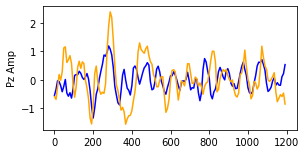

In [187]:
el_list = ['Pz']#['O1','O2','P3','P4']
plt.figure(figsize=(10, 5))
for ii,el in enumerate(el_list):
    ch = electrode_map[el]
    res = [[v for t, v in reg_trace_lst[idx][ch]] for idx in idx1[0].tolist()]
    array1 = np.array([np.array(epoch[:150]) for epoch in res])
    res = [[v for t, v in reg_trace_lst[idx][ch]] for idx in idx2[0].tolist()]
    array2 = np.array([np.array(epoch[:150]) for epoch in res])
    plt.subplot(2, 2, ii+1)
    plt.plot(xx, array1.mean(axis=0), 'blue', xx, array2.mean(axis=0), 'orange')
    plt.ylabel(el+' Amp')

In [21]:
import mne
from mne.datasets import sample

In [22]:
n_channels = len(electrodes)
sampling_rate = 125
channel_types = ['eeg']*len(electrodes)
montage = 'standard_1005'
info = mne.create_info(electrodes, sampling_rate, channel_types, montage)

<ipython-input-22-51117e35595d>:5: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  info = mne.create_info(electrodes, sampling_rate, channel_types, montage)


In [109]:
events = np.array([[ii, 1, m[0]] for ii,m in enumerate(markers_list)])

In [27]:
event_id = dict(x=1, o=2)

In [28]:
tmin = 0.0

In [ ]:
custom_epochs = mne.EpochsArray(data, info, events, tmin, event_id)

In [222]:
data = []
for epoch in range(len(reg_trace_lst)):
    epoch_arr = []
    for ch in range(len(reg_trace_lst[epoch])):
        epoch_arr.append(np.fromiter(reg_trace_lst[epoch][ch]._d.values()[:225], dtype=float))
    data.append(np.stack(epoch_arr))
data = np.stack(data)

In [236]:
fdata = mne.filter.notch_filter(data,sampling_rate,60,filter_length="1.5s",method="spectrum_fit")
fdata = mne.filter.filter_data(fdata,sampling_rate,1,None,filter_length=125,method="iir")

Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB



In [290]:
adata = np.apply_along_axis(lambda m: np.convolve(m, np.ones(10), mode='full')/10, axis=2, arr=fdata)

In [291]:
custom_epochs = mne.EpochsArray(adata, info, events, tmin, event_id)

149 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [292]:
evokedX = custom_epochs['x'].average()
evokedO = custom_epochs['o'].average()

In [293]:
evokedXPz = evokedX.copy().pick_channels(['Pz'])

In [294]:
evokedX

<Evoked  |  'x' (average, N=119), [0, 1.864] sec, 16 ch, ~79 kB>

In [295]:
evokedXPz.get_peak(tmin=.260, tmax=.600)

('Pz', 0.304)

Need more than one channel to make topography for eeg. Disabling interactivity.


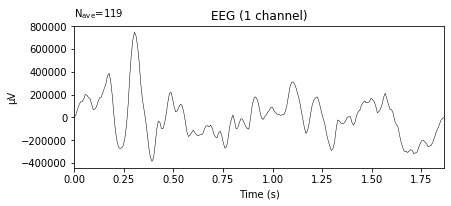

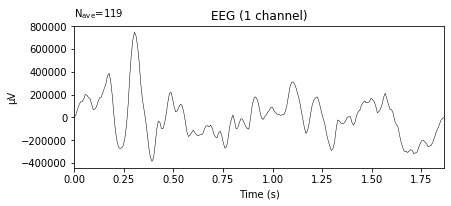

In [296]:
evokedXPz.plot()

In [297]:
evokedX

<Evoked  |  'x' (average, N=119), [0, 1.864] sec, 16 ch, ~79 kB>

In [272]:
contrast = mne.combine_evoked([evokedX, -evokedO], weights='equal')

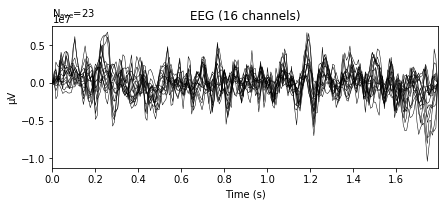

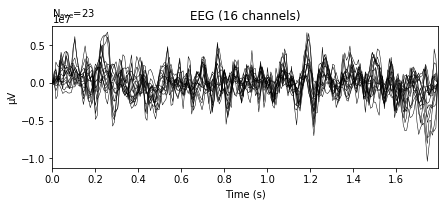

In [273]:
contrast.plot()

In [274]:
evoked = custom_epochs.average()

In [275]:
evoked

<Evoked  |  '0.80 * x + 0.20 * o' (average, N=149), [0, 1.792] sec, 16 ch, ~78 kB>

In [276]:
evokedPz = evoked.copy().pick_channels(['Pz'])

Need more than one channel to make topography for eeg. Disabling interactivity.


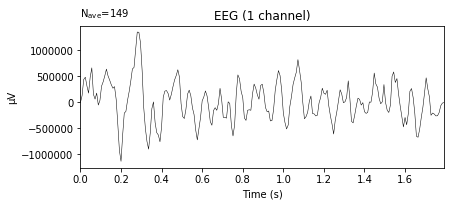

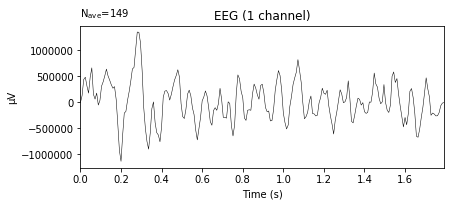

In [277]:
evokedPz.plot()